In [4]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#Setting some constants to use later
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 25

In [6]:
#Importing Dataset from dir
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True ,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
#storing class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

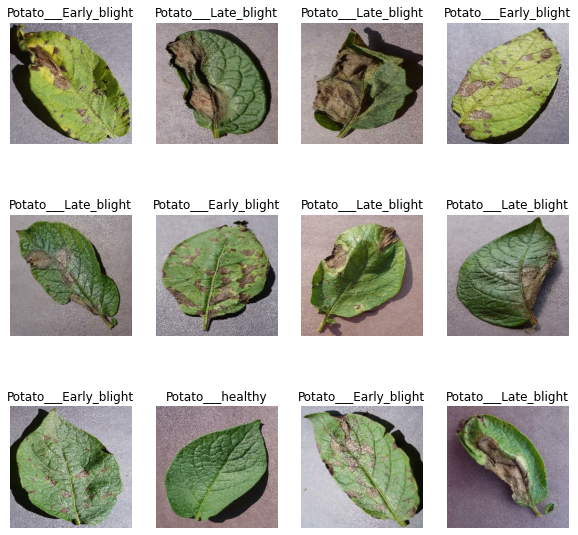

In [9]:
#plotting the first 12 pics of the 1st batch
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
80% ==> training
20% ==> 10% validation , 10% test

SyntaxError: invalid syntax (<ipython-input-11-59edef042068>, line 1)

In [ ]:
#Creating train_ds,val_ds,test_ds
def get_dataset_partitions_tf(ds,train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle=True ,shuffle_size = 10000) : 
    ds_size = len(ds)
    if shuffle:
        ds =ds.shuffle(shuffle_size , seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(test_ds)

In [ ]:
len(train_ds)

In [ ]:
len(val_ds)

In [ ]:
#cahcing and prefetching
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [ ]:
#resizing and scaling
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_scale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(
             optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
            )

In [ ]:
history =model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history.history.keys()

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS) , acc , label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc , label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS) , loss , label = "Training Loss")
plt.plot(range(EPOCHS), val_loss , label="Validation Loss")
plt.legend(loc='lower right')
plt.title("Training Loss and Validation Loss")

In [ ]:
for image_batch,label_batch in test_ds.take(1):
    first_image =image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's label: " , class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0 )
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [ ]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class} , \n Predicted : {predicted_class} , \n Confidence : {confidence}%")
        plt.axis("off")
        

In [ ]:
model_version=1
model.save(f"models/{model_version}")